# Analyzing NYC High School Data
The [SAT](https://en.wikipedia.org/wiki/SAT), or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on [student SAT scores](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) by high school, along with additional demographic data sets.

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

We will be combining the followind datasets for our analysis:

1. [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
2. [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
3. [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
4. [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
5. [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
6. [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
7. [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school




# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

Data Dictionary for survey data can be downloaded from 
[here](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8).

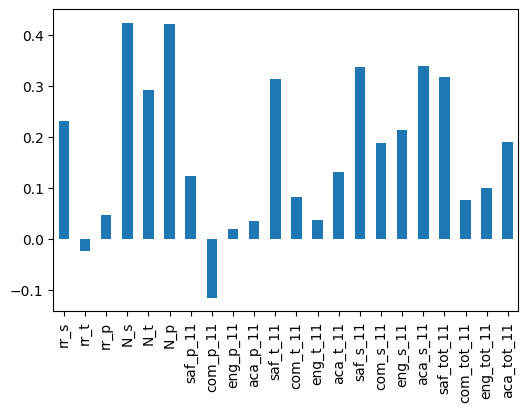

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

From the above we can observe the following:
1. There are high correlations with N-s,N_p and N_t columns because they represent total enrollment in SAT.
2. We can see that the rr_s which is the total response rate from students correlates positively with SAT score.This could be because students who clear SAT are more likely to respond to the survey.
3. We can also see the very high positive correlation in the aca_s_11 which is the student expectation of academic standards.However that is not the case with parents(aca_p_11) and teachers(aca_t_11)
4. The perception of safety of students and teachers(saf_s_11 and saf_s_11) relates positively with sat scores.This could be true because it is hard to learn or teach in unsafe places.

# Analyze safety scores

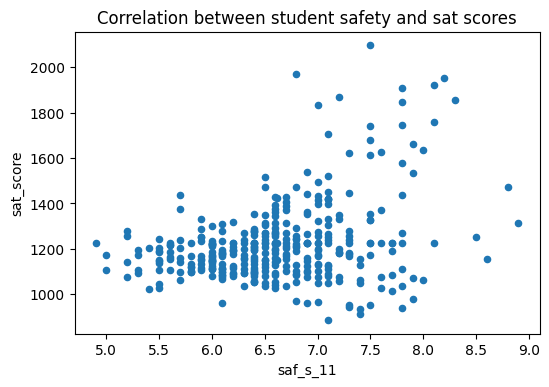

In [12]:
#Plot scatter plot of saf_s_11 vs sat_score 
combined.plot(kind="scatter",x="saf_s_11",y="sat_score",title="Correlation between student safety and sat scores")

From the above we can conclude that there is some correlation between student safety score and sat scores but it is not that strong.There are some schools with very high safety and sat score.Schools with safety score less than 6 generally have a sat score lower than 1500.

# Analyzing the safety scores borough wise

[Boroughs of New York City](http://www.nycgo.com/boroughs-neighborhoods)

In [13]:
# Avg safety scores for each borough
import numpy as np
borough_avg_safety_score=combined.groupby("boro").agg(np.mean)["saf_s_11"]
print(borough_avg_safety_score)


boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


From the above we can conclude that Manhattan and Queens have highest safety scores while Brooklyn has the lowest.

# Analyze racial differences in SAT scores

There are a few columns that indicate the percentage of each race at a given school:

* white_per
* asian_per
* black_per
* hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

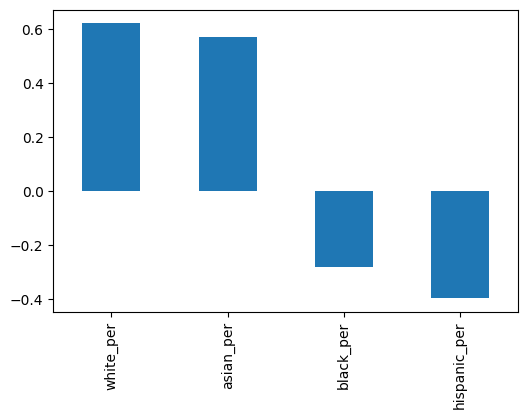

In [14]:
# Correlation between sat scores and races



combined.corr()["sat_score"][["white_per","asian_per","black_per","hispanic_per"]].plot.bar()

From the above we can cleary see there is a positive correlation between white and asian races and sat scores while negative correlation between hispanic and  black races meaning schools with higher percentage of white or asian students tend to score better than schools with higher percentage of black/hispanic students.

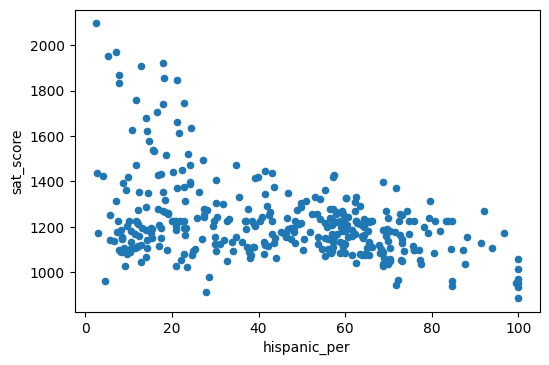

In [15]:
# Explore schools with low sat scores and high hispanic_per

combined.plot(kind="scatter",x="hispanic_per",y="sat_score")

From the above it is evident that schools with hispanic percent lower than 20% tend to have higher sat_scores than schools with hispanic_percent higher than 20%. Also schools with hispanic_per greatet than 90% tend to score very low in SATs.

In [16]:
# schools with a hispanic_per greater than 95%
hisp_greater_than_95=combined.loc[(combined["hispanic_per"]>95),"SCHOOL NAME"]

print(hisp_greater_than_95)

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [17]:
# schools with a hispanic_per less than 10%
hisp_less_than_10=combined.loc[(combined["hispanic_per"]<10),"SCHOOL NAME"]

print(hisp_less_than_10)

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

Many of the above schools are specially science and technology schools that receive funding.This explains the higher sat scores.

# Analyze gender wise difference in sat scores

There are two columns that indicate the percentage of each gender at a school:

* male_per
* female_per

We can plot out the correlations between each percentage and sat_score.

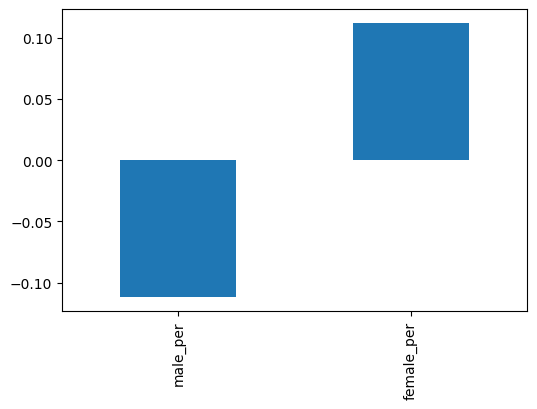

In [18]:
# Correlation between sat scores and gender



combined.corr()["sat_score"][["male_per","female_per"]].plot.bar()

From the above plot we can see that females have positive correlation with sat scores while male are negatively correlated.This states that schooles with higher female ratio tend to perform better at SAT exams than schools with higher male ratio

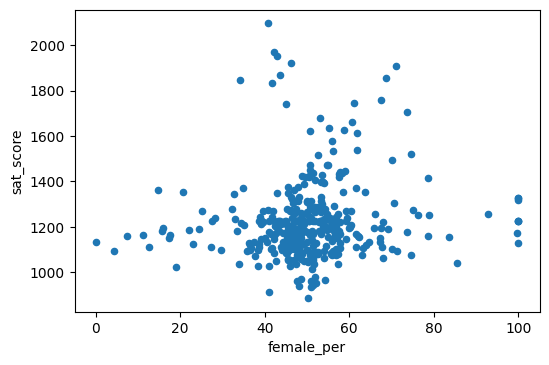

In [19]:
# Explore schools with high  sat scores and high female_per

combined.plot(kind="scatter",x="female_per",y="sat_score")

Based on the scatterplot there doesnt seem to be any correlation between sat scores and female_per.However there is a cluster where schools with female_per between 60 to 80 have higher sat scores.

In [20]:
# schools with a female_per greater than 60%
print(combined.loc[(combined["female_per"]>60) & (combined["sat_score"]>1700),"SCHOOL NAME"])


5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The above schools are very specific liberal arts school which have very good standards.

# Analyzing relation between AP Exams and SAT scores

In the U.S., high school students take [Advanced Placement](https://en.wikipedia.org/wiki/Advanced_Placement_exams) (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.


In [21]:
combined["ap_per"]=combined["AP Test Takers "]/combined["total_enrollment"]


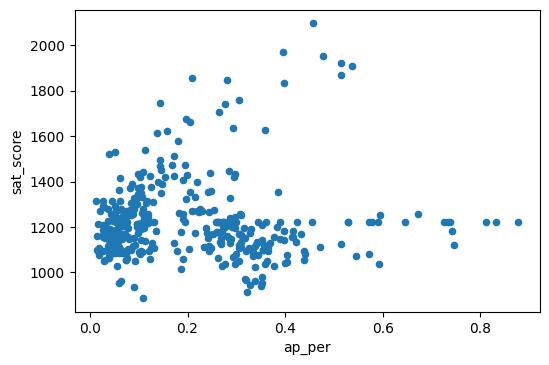

In [22]:
# Scatter plot of AP and SAT scores
combined.plot(kind="scatter",x="ap_per",y="sat_score")

From the above we can conclude that there is some relation between AP scores and SAT scores.However the correlation is not strong enough.